In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

sub_size = 10
X_size = 300

X_star = np.linspace(-1, 1, X_size)
X = X_star.reshape(-1,1)
# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int)  

X_sub = X[sorted_indices]
def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 1 # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup)  # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)     #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)      # Kernel Matrix Generated from the Total Sample Set and Subsample Sets
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                             # Primal form of the Sample Set Feature Function

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
KK = RBF_kernel(X, X_sub, kTup)    
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                

X_F_N = X_F[-1,:]
X_F_N = X_F_N.reshape(1, sub_size)

X = X_star
X = X.reshape(-1,1)
X = X[1:-1]
KK = RBF_kernel(X, X_sub, kTup)     

X_diag = np.diag(X.flatten())  # Sample Set Diagonal Matrix
X_sub_diag = np.diag(X_sub.flatten())  
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup) # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                 

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                  # First-Order Derivative of the Sample Set Feature Function             

X = X_star
X = X.reshape(-1,1)
X = X[1:-1]
KK = RBF_kernel(X, X_sub, kTup)    

X_diag_squa = np.square(X_diag)
X_sub_diag_squa = np.square(X_sub_diag)

# Second-order derivative of the kernel function
KK_DD = KK/(-kTup) + ( KK @ X_sub_diag_squa -  2 * X_diag @ KK @ X_sub_diag  + X_diag_squa @ KK ) / (kTup) 

eigenvalue, featurevector = np.linalg.eig(K)    
A = eigenvalue             
B = featurevector
K_1 = KK_DD @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_DD = K_1 @ A_lam
X_F_DD = F_DD                  # Second-Order Derivative of the Sample Set Feature Function               

from scipy.linalg import solve
r = 10000000   #Hyperparameter: gamma
# Differential equation parameters
nn = X_size - 2  # y
m_vars = sub_size # w
A = X_F_DD
B = X_F_D
C = X_F
D = X_F_1
E = X_F_N
I = np.ones((nn, 1))          # 1
p = 0.324027137
q = 0.324027137
e = np.e
F = np.eye(m_vars)      


max_iter = 400
tol = 1e-10
# Initial Guess 
w = np.zeros((m_vars, 1))
b = 0.0
m = 0.0
n = 0.0
y = np.zeros((nn, 1))+ 1e-3 
X= np.vstack([w,b, m, n, y]) 
# Construct the matrix equation and solve it.
# ====================================================
for iter in range(max_iter):
    Aw = A @ w            
    Bw = B @ w            
    Cw = C @ w             
    Dw = D @ w           
    Ew = E @ w           
    # ---------------------- F_res ----------------------
    # Y1:
    term1 = A.T @ (Aw - 2 * (Bw**2) / y + y)  
    term2 = 4 * B.T @ ((Bw / y) * (Aw - 2 * (Bw**2)/y + y))  
    term3 = -C.T @ (y - Cw - b * I)            
    Y1 = w + r * (term1 - term2) + r * term3 + m * D.T + n * E.T
    Y1 = Y1.squeeze()  
    
    # Y2:
    Y2 = r * (-I.T @ (y - Cw - b * I)) + m + n
    Y2 = Y2.item() 
    
    # Y3: 
    Y3 = (Dw + b - p).item()
    
    # Y4: 
    Y4 = (Ew + b - q).item()
    
    # Y5: 
    term5_1 = (2 * (Bw**2) / y + 1) * (Aw - 2 * (Bw**2)/y + y)
    term5_2 = y - Cw - b * I
    Y5 = r * (term5_1 + term5_2)
    Y5 = Y5.squeeze()  
    
    # [Y1, Y2, Y3, Y4, Y5] 
    F_res = np.concatenate([Y1, [Y2, Y3, Y4], Y5])
    
    residual_norm = np.linalg.norm(F_res)
    if residual_norm < tol:
        print(f"Convergence{iter} ，Norm: {residual_norm:.6e}")
        break
    
    # ---------------------- J ----------------------
    u = Bw / y           # Bw/y 
    v = Aw - 2*(Bw**2)/y + y  

    # --- ∂Y1/∂w  ---
    diag_u = np.diag(u.flatten()) @ B  # diag(u) * B 

    term1_w = F + r * A.T @ (A - 4 * diag_u)
    term2_w = -4 * r * B.T @ (
        np.diag(v.squeeze() / y.squeeze()) @ B + 
        np.diag(u.squeeze()) @ (A - 4 * diag_u)
    )
    term3_w = r * C.T @ C
    dY1_dw = term1_w + term2_w + term3_w 
    
    # --- ∂Y1/∂b  ---
    dY1_db = r * C.T @ I  
    
    # --- ∂Y1/∂m  ---
    dY1_dm = D.T 
    
    # --- ∂Y1/∂n  ---
    dY1_dn = E.T  
    
    # --- ∂Y1/∂y ---
    diag_2Bw2_y2 = np.diag(2 * (Bw.squeeze()**2) / (y.squeeze()**2))
    term1_y = r * A.T @ diag_2Bw2_y2  
    term2_y = -4 * r * B.T @ (
        np.diag((Bw.squeeze() * (2 * (Bw.squeeze()**2) / y.squeeze()**2 + 1)) / y.squeeze()) -
        np.diag((v.squeeze() * Bw.squeeze()) / y.squeeze()**2)
    )  
    term3_y = -r * C.T  
    dY1_dy = term1_y + term2_y + term3_y
    
    # --- ∂Y5/∂w  ---
    diag_term5w1 = np.diag(2 * (Bw.squeeze()**2)/y.squeeze() + 1)
    term5w1 = diag_term5w1 @ (A - 4 * np.diag(u.squeeze()) @ B)
    term5w2 = np.diag(v.flatten())@ np.diag(4 * u.flatten()) @ B
    dY5_dw = r * (term5w1 + term5w2) - r * C  
    
    # --- ∂Y5/∂b ---
    dY5_db = -r * I  
    
    # --- ∂Y5/∂y ---
    term1_y5 = -2 * (Bw**2) / (y**2) * (Aw - 2*(Bw**2)/y + y)
    term2_y5 = (2 * (Bw**2)/y + 1) * (2 * (Bw**2)/y**2 + 1)
    diag_term = term1_y5.squeeze() + term2_y5.squeeze() + 1
    dY5_dy = r * np.diag(diag_term)  
    
    # Y2
    dY2_dw = r * I.T @ C           
    dY2_db = r * I.T @ I          
    dY2_dm = 1.0
    dY2_dn = 1.0
    dY2_dy = -r * I.T           
    
    # Y3
    dY3_dw = D                  
    dY3_db = 1.0
    dY3_dm = 0.0
    dY3_dn = 0.0
    dY3_dy = np.zeros((1, nn))    
    
    # Y4
    dY4_dw = E                    
    dY4_db = 1.0
    dY4_dm = 0.0
    dY4_dn = 0.0
    dY4_dy = np.zeros((1, nn))     
    
    # ================= J =================
    J = np.zeros((nn+m_vars+3, nn+m_vars+3))
    
    J[:m_vars, :m_vars] = dY1_dw
    J[:m_vars, m_vars] = dY1_db.squeeze()
    J[:m_vars, m_vars+1] = dY1_dm.squeeze()
    J[:m_vars, m_vars+2] = dY1_dn.squeeze()
    J[:m_vars, m_vars+3:] = dY1_dy
    
    J[m_vars, :m_vars] = dY2_dw          
    J[m_vars, m_vars] = dY2_db           
    J[m_vars, m_vars+1] = dY2_dm           
    J[m_vars, m_vars+2] = dY2_dn           
    J[m_vars, m_vars+3:] = dY2_dy          
    
    J[m_vars+1, :m_vars] = dY3_dw          
    J[m_vars+1, m_vars] = dY3_db           # 1
    J[m_vars+1, m_vars+1:m_vars+4] = 0           
    J[m_vars+1, m_vars+3:] = dY3_dy         
    
    J[m_vars+2, :m_vars] = dY4_dw          
    J[m_vars+2, m_vars] = dY4_db           # 1
    J[m_vars+2, m_vars+1:m_vars+4] = 0            
    J[m_vars+2, m_vars+3:] = dY4_dy          
    
    J[m_vars+3:, :m_vars] = dY5_dw          
    J[m_vars+3:, m_vars] = dY5_db.squeeze() 
    J[m_vars+3:, m_vars+1] = 0                
    J[m_vars+3:, m_vars+2] = 0                
    J[m_vars+3:, m_vars+3:] = dY5_dy          
    
    # =================  J * delta = -F_res =================
    delta = solve(J, -F_res)
    delta = np.real(delta)

    w += delta[:m_vars].reshape(-1, 1)
    b += delta[m_vars]
    m += delta[m_vars+1]
    n += delta[m_vars+2]
    y += delta[m_vars+3:].reshape(-1, 1)
    
    print(f"Iter {iter}: Residual norm = {residual_norm:.6e}")

else:
    print(f"{max_iter}，{residual_norm:.6e}")
    
#Calculate the prediction results.
X = X_star
X = X.reshape(-1,1)
KK = RBF_kernel(X, X_sub, kTup)    
eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)
F = K_1 @ A_lam
X_F = F                                

y_p =  np.real(np.dot(X_F,w) + b.item())

print(y_p.shape)

C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=2.7255e-21): result may not be accurate.
  delta = solve(J, -F_res)
C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=3.80133e-21): result may not be accurate.
  delta = solve(J, -F_res)
C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=4.61268e-21): result may not be accurate.
  delta = solve(J, -F_res)
C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=5.5482e-21): result may not be accurate.
  delta = solve(J, -F_res)
C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=4.91134e-21): result may not be accurate.
  delta = solve(J, -F_res)
C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill

Iter 0: Residual norm = 1.473127e+07
Iter 1: Residual norm = 1.162745e+09
Iter 2: Residual norm = 2.808950e+08
Iter 3: Residual norm = 2.660658e+08
Iter 4: Residual norm = 1.143213e+08
Iter 5: Residual norm = 4.488398e+07
Iter 6: Residual norm = 1.662313e+07
Iter 7: Residual norm = 7.903611e+06
Iter 8: Residual norm = 5.911100e+06
Iter 9: Residual norm = 4.588805e+06
Iter 10: Residual norm = 3.275866e+06
Iter 11: Residual norm = 2.175328e+06
Iter 12: Residual norm = 1.366439e+06
Iter 13: Residual norm = 8.206531e+05
Iter 14: Residual norm = 4.740048e+05
Iter 15: Residual norm = 2.639562e+05
Iter 16: Residual norm = 1.416724e+05
Iter 17: Residual norm = 7.306917e+04
Iter 18: Residual norm = 3.598802e+04
Iter 19: Residual norm = 1.675421e+04
Iter 20: Residual norm = 7.286694e+03
Iter 21: Residual norm = 3.011006e+03
Iter 22: Residual norm = 1.432892e+03


C:\Users\90765\AppData\Local\Temp\ipykernel_72608\3797469920.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=4.89154e-21): result may not be accurate.
  delta = solve(J, -F_res)


Iter 23: Residual norm = 1.004794e+03
Iter 24: Residual norm = 7.988421e+02
Iter 25: Residual norm = 6.021062e+02
Iter 26: Residual norm = 4.247389e+02
Iter 27: Residual norm = 2.839646e+02
Iter 28: Residual norm = 1.818892e+02
Iter 29: Residual norm = 1.124288e+02
Iter 30: Residual norm = 6.736018e+01
Iter 31: Residual norm = 3.921442e+01
Iter 32: Residual norm = 2.220170e+01
Iter 33: Residual norm = 1.221770e+01
Iter 34: Residual norm = 6.521664e+00
Iter 35: Residual norm = 3.363273e+00
Iter 36: Residual norm = 1.664664e+00
Iter 37: Residual norm = 7.827169e-01
Iter 38: Residual norm = 3.450287e-01
Iter 39: Residual norm = 1.429059e-01
Iter 40: Residual norm = 6.377070e-02
Iter 41: Residual norm = 4.175941e-02
Iter 42: Residual norm = 3.351380e-02
Iter 43: Residual norm = 2.590877e-02
Iter 44: Residual norm = 1.870884e-02
Iter 45: Residual norm = 1.279814e-02
Iter 46: Residual norm = 8.367712e-03
Iter 47: Residual norm = 5.294700e-03
Iter 48: Residual norm = 3.245207e-03
Iter 49: Res

Iter 290: Residual norm = 1.079800e-05
Iter 291: Residual norm = 9.518090e-06
Iter 292: Residual norm = 1.874808e-06
Iter 293: Residual norm = 8.163200e-06
Iter 294: Residual norm = 4.529140e-06
Iter 295: Residual norm = 3.198843e-06
Iter 296: Residual norm = 5.229774e-06
Iter 297: Residual norm = 1.798937e-06
Iter 298: Residual norm = 5.707563e-06
Iter 299: Residual norm = 2.946590e-06
Iter 300: Residual norm = 9.688428e-07
Iter 301: Residual norm = 6.992088e-06
Iter 302: Residual norm = 2.799705e-06
Iter 303: Residual norm = 8.513695e-06
Iter 304: Residual norm = 4.741106e-06
Iter 305: Residual norm = 3.915124e-06
Iter 306: Residual norm = 6.165738e-06
Iter 307: Residual norm = 3.594347e-06
Iter 308: Residual norm = 1.149984e-06
Iter 309: Residual norm = 2.931231e-06
Iter 310: Residual norm = 1.143281e-06
Iter 311: Residual norm = 7.695614e-06
Iter 312: Residual norm = 5.155648e-06
Iter 313: Residual norm = 2.231075e-06
Iter 314: Residual norm = 1.009741e-05
Iter 315: Residual norm =

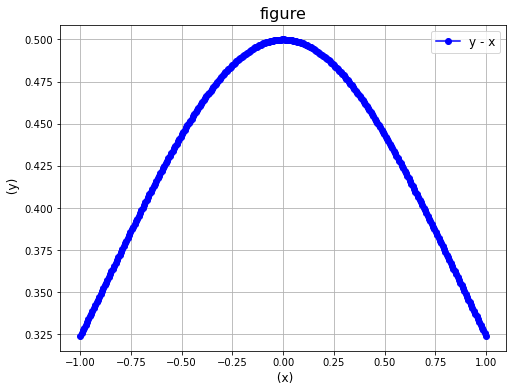

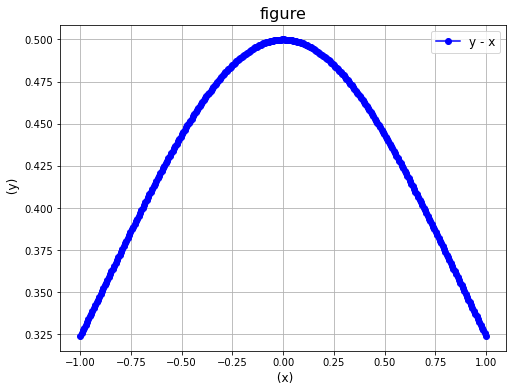

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = X 
a = y_p
y = y_p           
plt.figure(figsize=(8, 6))  
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

x = X
y_t = 0.5 / np.cosh(x)
y_t = np.array(y_t)
b = y_t
y = y_t              
plt.figure(figsize=(8, 6)) 
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true.reshape(-1, 1))
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true.reshape(-1, 1))
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true.reshape(-1, 1), squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)
print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 


import pandas as pd

data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})

data_to_save.to_csv('fsvm_15.csv', index=False)
print("fsvm_15.csv")

R2_fsvm: 0.9999999999871452, mae_fsvm: 1.6750005639073103e-07, rmse_fsvm: 1.9764641337445297e-07, inf_norm_fsvm: 3.464739207204026e-07
数据已保存至 fsvm_15.csv
